<a href="https://colab.research.google.com/github/lazarussim12-beep/DLI_GRP_Assignment/blob/Khoo-Zi-Ming/DLI_Group_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import all required library


In [ ]:
import os
import re
import time
import zipfile
import pickle
import random

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.svm import SVC
from typing import Tuple

import xgboost as xgb
import lightgbm as lgb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout,
    LSTM,
    Bidirectional,
    Input,
    GRU,
)
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import joblib

from sklearn.utils.validation import check_is_fitted
from tabulate import tabulate



# Import Dataset


--2025-08-23 10:17:59--  https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip [following]
--2025-08-23 10:17:59--  https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15642124 (15M) [application/zip]
Saving to: ‘enron_spam_data.zip’

enron_spam_data.zip 100%[=

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14



Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

=== SPAM vs HAM Analysis ===
Using column: 'Spam/Ham'
Counts by category:
Spam/Ham
spam    17171
ham     16545
Name: count, dtype: int64

Percentages by category:
spam: 50.93%
ham: 49.07%

Detailed Analysis:
Total emails: 33716
ham: 16545 emails (49.07%)
spam: 17171 emails (50.93%)


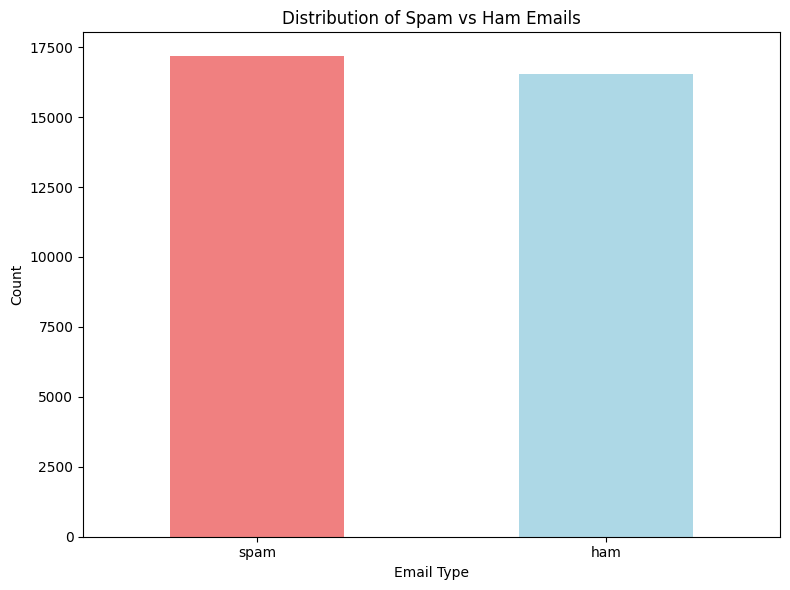

In [ ]:
# Download the zip file from GitHub
!wget https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip

# Unzip the file
import zipfile
with zipfile.ZipFile('enron_spam_data.zip', 'r') as zip_ref:
    zip_ref.extractall('enron_data')

# List extracted files (to verify)
import os
extracted_files = os.listdir('enron_data')
print("Extracted files:", extracted_files)

# Load the CSV file(s) into pandas
import pandas as pd

for file in extracted_files:
    if file.endswith('.csv'):
        df = pd.read_csv(f'enron_data/{file}')
        print(f"Loaded {file} with shape:", df.shape)

        # Display first few rows
        display(df.head())

        print(f"\nColumn names: {df.columns.tolist()}")

        # Calculate number of spam and ham in the Spam/Ham column
        print("\n=== SPAM vs HAM Analysis ===")

        spam_col = None
        for col in df.columns:
            if 'spam' in col.lower() or 'ham' in col.lower():
                spam_col = col
                break

        if spam_col is None:
            spam_col = df.columns[3] if len(df.columns) > 3 else df.columns[-1]

        print(f"Using column: '{spam_col}'")

        # Count values in the spam/ham column
        spam_ham_counts = df[spam_col].value_counts()
        print("Counts by category:")
        print(spam_ham_counts)

        # Calculate percentages
        spam_ham_percentages = df[spam_col].value_counts(normalize=True) * 100
        print("==========================")
        print("\nPercentages by category:")
        for category, percentage in spam_ham_percentages.items():
            print(f"{category}: {percentage:.2f}%")

        # More detailed analysis
        total_emails = len(df)
        print("==========================")
        print(f"\nDetailed Analysis:")
        print(f"Total emails: {total_emails}")

        for category in df[spam_col].unique():
            count = (df[spam_col] == category).sum()
            percentage = (count / total_emails) * 100
            print(f"{category}: {count} emails ({percentage:.2f}%)")

        try:
            import matplotlib.pyplot as plt

            plt.figure(figsize=(8, 6))
            spam_ham_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
            plt.title('Distribution of Spam vs Ham Emails')
            plt.xlabel('Email Type')
            plt.ylabel('Count')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        except ImportError:
            print("\nMatplotlib not available for visualization")

        break

# Lazarus Sim Wen Hui Code


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
759/759 - 15s - 19ms/step - accuracy: 0.9255 - loss: 0.1677 - val_accuracy: 0.9744 - val_loss: 0.0624
Epoch 2/5
759/759 - 10s - 14ms/step - accuracy: 0.9845 - loss: 0.0467 - val_accuracy: 0.9811 - val_loss: 0.0599
Epoch 3/5
759/759 - 2s - 3ms/step - accuracy: 0.9914 - loss: 0.0265 - val_accuracy: 0.9785 - val_loss: 0.0658
Epoch 4/5
759/759 - 3s - 4ms/step - accuracy: 0.9938 - loss: 0.0196 - val_accuracy: 0.9815 - val_loss: 0.0662
Epoch 5/5
759/759 - 3s - 4ms/step - accuracy: 0.9946 - loss: 0.0160 - val_accuracy: 0.9759 - val_loss: 0.0996


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:29:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 13736, number of negative: 13236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.115898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 917212
[LightGBM] [Info] Number of data points in the train set: 26972, number of used features: 9971
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509269 -> initscore=0.037080
[LightGBM] [Info] Start training from score 0.037080


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



MODEL EVALUATION TABLE (THRESH=0.5): Accuracy, Precision, Recall, F1, ROC-AUC, Params/Size, Inference time (ms)
+------------------------------------+-------+--------+-------+-------+-------+---------------------------+------------------+
| Model                              |   Acc |   Prec |   Rec |    F1 |   AUC | Size/Params               |   Inference (ms) |
+====================================+=======+========+=======+=======+=======+===========================+==================+
| Logistic Regression (TF-IDF)       | 0.986 |  0.979 | 0.994 | 0.986 | 0.998 | params=10,001             |            2.490 |
+------------------------------------+-------+--------+-------+-------+-------+---------------------------+------------------+
| Logistic Regression (CNN-features) | 0.981 |  0.976 | 0.987 | 0.982 | 0.998 | params=65                 |            1.010 |
+------------------------------------+-------+--------+-------+-------+-------+---------------------------+------------------

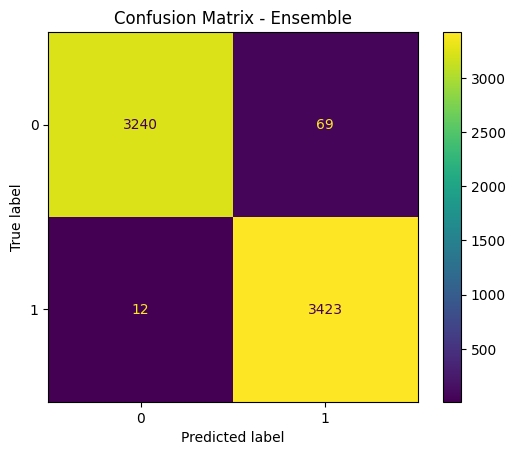

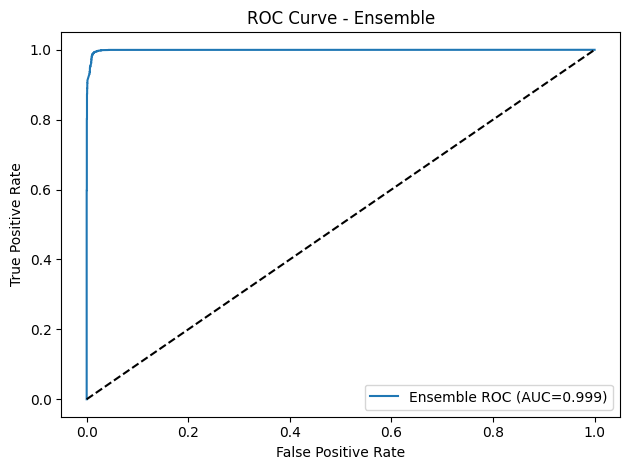

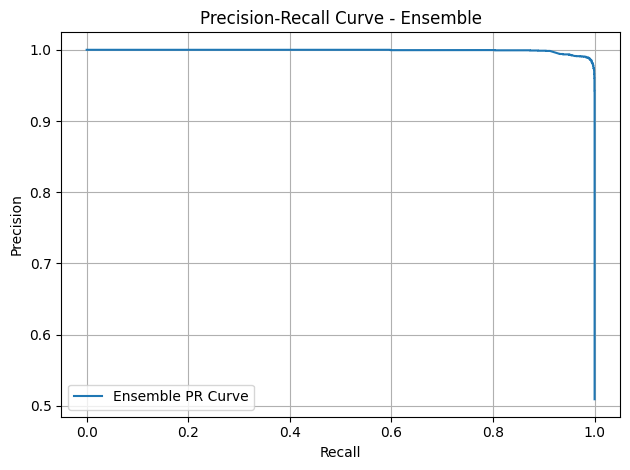


Total runtime: 218.23 seconds (3 minutes 38.23 seconds)
Achieved F1 (Ensemble) = 0.99. Target met


In [ ]:
start_time = time.time()

#LAZMODEL
# === Reproducibility: fix random seeds ===
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Basic cleaning
df['Message'] = (
    df['Message']
    .astype(str)
    .str.lower()
    .apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
)
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})

X = df['Message'].values
y = df['Spam/Ham'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Tokenization and padding for CNN branch ===
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=max_len)

# === CNN feature extractor model ===
cnn_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# === Helpers: timing and size reporting ===
def time_fit_keras(model, X, y, **fit_kwargs):
    t0 = time.time()
    history = model.fit(X, y, **fit_kwargs)
    ms = (time.time() - t0) * 1000
    return history, ms

def time_fit_sklearn(model, X, y):
    t0 = time.time()
    model.fit(X, y)
    ms = (time.time() - t0) * 1000
    return model, ms

def measure_inference_time(model, X_test_data, model_type='sklearn'):
    t0 = time.time()
    if model_type == 'sklearn':
        _ = model.predict(X_test_data)
    elif model_type == 'keras':
        _ = model.predict(X_test_data, verbose=0)
    return (time.time() - t0) * 1000

def logreg_param_count(lr_model):
    return lr_model.coef_.size + lr_model.intercept_.size

def keras_param_count(model):
    return model.count_params()

def xgb_complexity(xgb_model):
    # Trees + depth proxy
    n_trees = xgb_model.get_booster().num_boosted_rounds()
    max_depth = xgb_model.get_params().get('max_depth', None)
    return f"trees={n_trees}, max_depth={max_depth}"

def lgb_complexity(lgb_model):
    n_trees = lgb_model.get_params().get('n_estimators', getattr(lgb_model, 'n_estimators', None))
    num_leaves = lgb_model.get_params().get('num_leaves', getattr(lgb_model, 'num_leaves', None))
    return f"trees={n_trees}, num_leaves={num_leaves}"

# === Train CNN ===
cnn_history, cnn_train_ms = time_fit_keras(
    cnn_model, X_train_seq, y_train,
    batch_size=32, epochs=5, validation_split=0.1, verbose=2
)
cnn_infer_ms = measure_inference_time(cnn_model, X_test_seq, 'keras')
cnn_total_params = keras_param_count(cnn_model)

# === Extract CNN features (output from GlobalMaxPooling1D layer) ===
feature_extractor = Model(inputs=cnn_model.layers[0].input, outputs=cnn_model.layers[4].output)
X_train_cnn_feat = feature_extractor.predict(X_train_seq, verbose=0)
X_test_cnn_feat  = feature_extractor.predict(X_test_seq,  verbose=0)

# === TF-IDF features with n-grams ===
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# === Logistic Regression on TF-IDF (timed) ===
lr = LogisticRegression(max_iter=1000, random_state=42)
lr, lr_train_ms = time_fit_sklearn(lr, X_train_tfidf, y_train)
lr_pred  = lr.predict(X_test_tfidf)
lr_proba = lr.predict_proba(X_test_tfidf)[:, 1]
lr_infer_ms = measure_inference_time(lr, X_test_tfidf, 'sklearn')
lr_params = logreg_param_count(lr)

# === Logistic Regression on CNN features (timed) ===
lr_cnn_only = LogisticRegression(max_iter=1000, random_state=42)
lr_cnn_only, lr_cnn_train_ms = time_fit_sklearn(lr_cnn_only, X_train_cnn_feat, y_train)
lr_cnn_pred  = lr_cnn_only.predict(X_test_cnn_feat)
lr_cnn_proba = lr_cnn_only.predict_proba(X_test_cnn_feat)[:, 1]
lr_cnn_infer_ms = measure_inference_time(lr_cnn_only, X_test_cnn_feat, 'sklearn')
lr_cnn_params = logreg_param_count(lr_cnn_only)

# === XGBoost on TF-IDF (timed) ===
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb_model, xgb_train_ms = time_fit_sklearn(xgb_model, X_train_tfidf, y_train)
xgb_pred  = xgb_model.predict(X_test_tfidf)
xgb_proba = xgb_model.predict_proba(X_test_tfidf)[:, 1]
xgb_infer_ms = measure_inference_time(xgb_model, X_test_tfidf, 'sklearn')
xgb_size = xgb_complexity(xgb_model)

# === LightGBM on TF-IDF (timed) ===
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model, lgb_train_ms = time_fit_sklearn(lgb_model, X_train_tfidf, y_train)
lgb_pred  = lgb_model.predict(X_test_tfidf)
lgb_proba = lgb_model.predict_proba(X_test_tfidf)[:, 1]
lgb_infer_ms = measure_inference_time(lgb_model, X_test_tfidf, 'sklearn')
lgb_size = lgb_complexity(lgb_model)

# === Soft Voting Ensemble (XGB + LGB + CNN + LR) ===
ensemble_soft_no_rf_proba = (xgb_proba + lgb_proba + lr_cnn_proba + lr_proba) / 4

# Threshold
THRESH = 0.5
ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba > THRESH).astype(int)

# === ROC-AUC for all models ===
lr_auc       = roc_auc_score(y_test, lr_proba)
lr_cnn_auc   = roc_auc_score(y_test, lr_cnn_proba)
xgb_auc      = roc_auc_score(y_test, xgb_proba)
lgb_auc      = roc_auc_score(y_test, lgb_proba)
ensemble_auc = roc_auc_score(y_test, ensemble_soft_no_rf_proba)

# === Metrics helper ===
def all_scores(y_true, y_pred):
    return (
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred),
    )

# === Calculate metrics for all models ===
models_results = []

# Logistic Regression (TF-IDF)
lr_acc, lr_prec, lr_rec, lr_f1 = all_scores(y_test, lr_pred)
models_results.append([
    'Logistic Regression (TF-IDF)',
    lr_acc, lr_prec, lr_rec, lr_f1, lr_auc,
    f"params={lr_params:,}",
    f"train_ms={lr_train_ms:.2f}, infer_ms={lr_infer_ms:.2f}"
])

# Logistic Regression (CNN features)
lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1 = all_scores(y_test, lr_cnn_pred)
models_results.append([
    'Logistic Regression (CNN-features)',
    lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1, lr_cnn_auc,
    f"params={lr_cnn_params:,}",
    f"train_ms={lr_cnn_train_ms:.2f}, infer_ms={lr_cnn_infer_ms:.2f}"
])

# XGBoost
xgb_acc, xgb_prec, xgb_rec, xgb_f1 = all_scores(y_test, xgb_pred)
models_results.append([
    'XGBoost (TF-IDF)',
    xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_auc,
    xgb_size,  # complexity proxy
    f"train_ms={xgb_train_ms:.2f}, infer_ms={xgb_infer_ms:.2f}"
])

# LightGBM
lgb_acc, lgb_prec, lgb_rec, lgb_f1 = all_scores(y_test, lgb_pred)
models_results.append([
    'LightGBM (TF-IDF)',
    lgb_acc, lgb_prec, lgb_rec, lgb_f1, lgb_auc,
    lgb_size,  # complexity proxy
    f"train_ms={lgb_train_ms:.2f}, infer_ms={lgb_infer_ms:.2f}"
])

# CNN (as a classifier itself at THRESH)
# We can also report the CNN's own metrics if you want:
cnn_proba = cnn_model.predict(X_test_seq, verbose=0).ravel()
cnn_pred  = (cnn_proba > THRESH).astype(int)
cnn_acc, cnn_prec, cnn_rec, cnn_f1 = all_scores(y_test, cnn_pred)
cnn_auc = roc_auc_score(y_test, cnn_proba)
models_results.append([
    'CNN (Keras)',
    cnn_acc, cnn_prec, cnn_rec, cnn_f1, cnn_auc,
    f"params={cnn_total_params:,}",
    f"train_ms={cnn_train_ms:.2f}, infer_ms={cnn_infer_ms:.2f}"
])

# Ensemble
ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1 = all_scores(y_test, ensemble_soft_no_rf_pred)
ensemble_infer_ms = measure_inference_time(lr, X_test_tfidf, 'sklearn') \
                    + measure_inference_time(lr_cnn_only, X_test_cnn_feat, 'sklearn') \
                    + measure_inference_time(xgb_model, X_test_tfidf, 'sklearn') \
                    + measure_inference_time(lgb_model, X_test_tfidf, 'sklearn')
ensemble_train_ms = lr_train_ms + lr_cnn_train_ms + xgb_train_ms + lgb_train_ms + cnn_train_ms  # if you want to include CNN pretraining cost

models_results.append([
    'Ensemble (XGB+LGB+CNN+LR)',
    ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_auc,
    "combined (see rows)",
    f"train_ms≈{ensemble_train_ms:.2f}, infer_ms≈{ensemble_infer_ms:.2f}"
])

# Print Result
headers = ["Model", "Acc", "Prec", "Rec", "F1", "AUC", "Size/Params", "Inference (ms)"]

rows = [
    ["Logistic Regression (TF-IDF)",        lr_acc,     lr_prec,     lr_rec,     lr_f1,     lr_auc,     f"params={lr_params:,}",              f"{lr_infer_ms:.2f}"],
    ["Logistic Regression (CNN-features)",  lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1, lr_cnn_auc, f"params={lr_cnn_params:,}",          f"{lr_cnn_infer_ms:.2f}"],
    ["XGBoost (TF-IDF)",                    xgb_acc,    xgb_prec,    xgb_rec,    xgb_f1,    xgb_auc,    xgb_size,                              f"{xgb_infer_ms:.2f}"],
    ["LightGBM (TF-IDF)",                   lgb_acc,    lgb_prec,    lgb_rec,    lgb_f1,    lgb_auc,    lgb_size,                              f"{lgb_infer_ms:.2f}"],
    ["CNN (Keras)",                         cnn_acc,    cnn_prec,    cnn_rec,    cnn_f1,    cnn_auc,    f"params={cnn_total_params:,}",        f"{cnn_infer_ms:.2f}"],
    ["Ensemble (XGB+LGB+CNN+LR)",           ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_auc,
                                            "combined (see rows)",                                           f"{(lr_infer_ms + lr_cnn_infer_ms + xgb_infer_ms + lgb_infer_ms):.2f}"],
]

print("\nMODEL EVALUATION TABLE (THRESH=0.5): Accuracy, Precision, Recall, F1, ROC-AUC, Params/Size, Inference time (ms)")
print(tabulate(rows, headers=headers, tablefmt="grid", floatfmt=".3f"))

print("\nNotes:")
print("• Tree models: report structural complexity (trees/depth/leaves) instead of parameter count.")
print("• Keras/LogReg: report true parameter counts.")


# === Visuals for the Ensemble ===
ConfusionMatrixDisplay(confusion_matrix(y_test, ensemble_soft_no_rf_pred)).plot()
plt.title('Confusion Matrix - Ensemble')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC={ensemble_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble'); plt.legend(loc='lower right'); plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(recall, precision, label='Ensemble PR Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble'); plt.legend(loc='lower left'); plt.grid(True)
plt.tight_layout(); plt.show()

time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

target_f1 = 0.98
print(f"Achieved F1 (Ensemble) = {ensemble_f1:.2f}. {'Target met' if ensemble_f1 >= target_f1 else 'Target not met'}")



Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


759/759 - 65s - 86ms/step - accuracy: 0.9256 - loss: 0.1696 - val_accuracy: 0.9759 - val_loss: 0.0645
Epoch 2/5
759/759 - 64s - 84ms/step - accuracy: 0.9843 - loss: 0.0477 - val_accuracy: 0.9792 - val_loss: 0.0563
Epoch 3/5
759/759 - 79s - 104ms/step - accuracy: 0.9919 - loss: 0.0250 - val_accuracy: 0.9770 - val_loss: 0.0835
Epoch 4/5
759/759 - 60s - 79ms/step - accuracy: 0.9927 - loss: 0.0212 - val_accuracy: 0.9785 - val_loss: 0.0828
Epoch 5/5
759/759 - 82s - 108ms/step - accuracy: 0.9939 - loss: 0.0169 - val_accuracy: 0.9789 - val_loss: 0.0791
843/843 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 13736, number of negative: 13236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.633655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 917311
[LightGBM] [Info] Number of data points in the train set: 26972, number of used features: 9970
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509269 -> initscore=0.037080
[LightGBM] [Info] Start training from score 0.037080


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, ROC-AUC, Params, Inference Time
Model                               Accuracy   Precision  Recall     F1         ROC-AUC    Params     Inference (ms) 
--------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression (TF-IDF)        0.99       0.98       0.99       0.99       0.998      10001      3.12           
Logistic Regression (CNN)           0.98       0.98       0.99       0.98       0.998      65         1.85           
XGBoost                             0.98       0.97       0.99       0.98       0.998      10000      37.72          
LightGBM                            0.98       0.97       0.99       0.98       0.998      10000      97.98          
Ensemble (XGB+LGB+CNN+LR)           0.99       0.98       0.99       0.99       0.999      Combined   140.67         
-------------------------------------------------------------

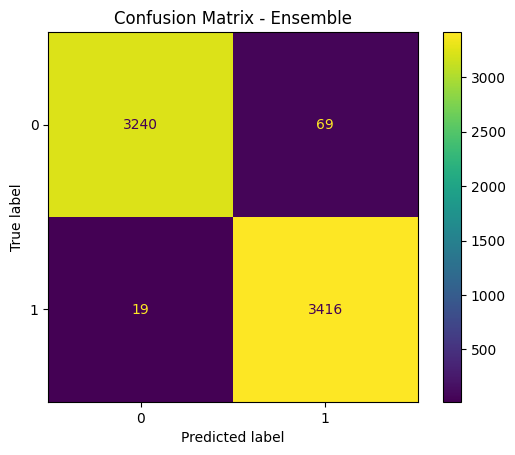

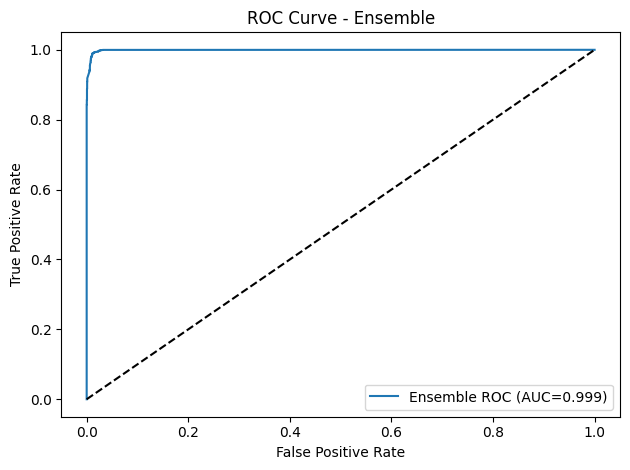

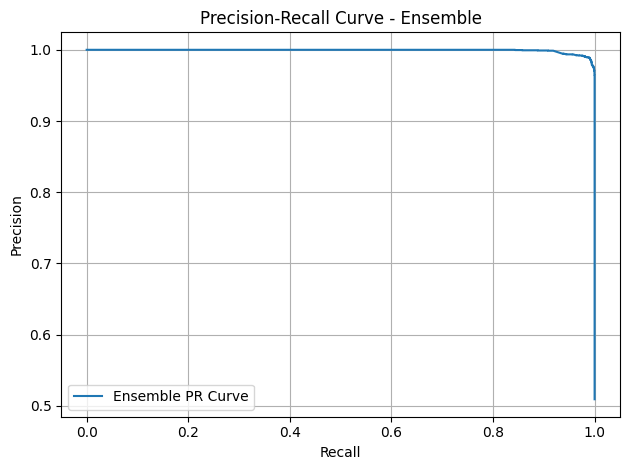


Total runtime: 627.02 seconds (10 minutes 27.02 seconds)
Achieved F1 (Ensemble) = 0.99. Target met


In [ ]:
# # Reproducibility: fix random seeds
# os.environ['PYTHONHASHSEED'] = '42'
# np.random.seed(42)
# random.seed(42)
# tf.random.set_seed(42)

# df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
# df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
# X = df['Message'].values
# y = df['Spam/Ham'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Tokenization and padding
# max_words = 10000
# max_len = 100
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(X_train)
# X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
# X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# # CNN feature extractor model
# model = Sequential([
#     Embedding(max_words, 128, input_length=max_len),
#     Conv1D(128, 5, activation='relu'),
#     Dropout(0.3),
#     Conv1D(64, 3, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train CNN feature extractor
# start_time = time.time()
# model.fit(
#     X_train_seq, y_train,
#     batch_size=32,
#     epochs=5,
#     validation_split=0.1,
#     verbose=2
# )

# # Extract CNN features (output from GlobalMaxPooling1D layer)
# feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
# X_train_cnn_feat = feature_extractor.predict(X_train_seq)
# X_test_cnn_feat = feature_extractor.predict(X_test_seq)

# # TF-IDF features with n-grams
# vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # Function to calculate model parameters count
# def count_parameters(model):
#     if hasattr(model, 'count_params'):
#         return model.count_params()
#     elif hasattr(model, 'n_features_in_'):
#         if hasattr(model, 'coef_'):
#             return model.coef_.size + 1
#         else:
#             return model.n_features_in_
#     else:
#         return "N/A"

# # Function to measure inference time
# def measure_inference_time(model, X_test_data, model_type='sklearn'):
#     start_time = time.time()
#     if model_type == 'sklearn':
#         model.predict(X_test_data)
#     elif model_type == 'keras':
#         model.predict(X_test_data, verbose=0)
#     end_time = time.time()
#     return (end_time - start_time) * 1000

# # Logistic Regression on TF-IDF
# lr = LogisticRegression(max_iter=1000, random_state=42)
# lr.fit(X_train_tfidf, y_train)
# lr_pred = lr.predict(X_test_tfidf)
# lr_proba = lr.predict_proba(X_test_tfidf)[:, 1]

# # Logistic Regression on CNN features
# lr_cnn_only = LogisticRegression(max_iter=1000, random_state=42)
# lr_cnn_only.fit(X_train_cnn_feat, y_train)
# lr_cnn_pred = lr_cnn_only.predict(X_test_cnn_feat)
# lr_cnn_proba = lr_cnn_only.predict_proba(X_test_cnn_feat)[:, 1]

# # XGBoost
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_model.fit(X_train_tfidf, y_train)
# xgb_pred = xgb_model.predict(X_test_tfidf)
# xgb_proba = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# # LightGBM
# lgb_model = lgb.LGBMClassifier(random_state=42)
# lgb_model.fit(X_train_tfidf, y_train)
# lgb_pred = lgb_model.predict(X_test_tfidf)
# lgb_proba = lgb_model.predict_proba(X_test_tfidf)[:, 1]

# #Soft Voting Ensemble (XGB+LGB+CNN+LR only)
# ensemble_soft_no_rf_proba = (xgb_proba + lgb_proba + lr_cnn_proba + lr_proba) / 4
# ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba > 0.5).astype(int)

# # ROC-AUC for all models
# lr_auc = roc_auc_score(y_test, lr_proba)
# lr_cnn_auc = roc_auc_score(y_test, lr_cnn_proba)
# xgb_auc = roc_auc_score(y_test, xgb_proba)
# lgb_auc = roc_auc_score(y_test, lgb_proba)
# ensemble_auc = roc_auc_score(y_test, ensemble_soft_no_rf_proba)

# # Calculate metrics for all models
# models_results = []

# # Logistic Regression (TF-IDF)
# lr_acc = accuracy_score(y_test, lr_pred)
# lr_prec = precision_score(y_test, lr_pred)
# lr_rec = recall_score(y_test, lr_pred)
# lr_f1 = f1_score(y_test, lr_pred)
# lr_params = count_parameters(lr)
# lr_inference = measure_inference_time(lr, X_test_tfidf, 'sklearn')
# models_results.append(['Logistic Regression (TF-IDF)', lr_acc, lr_prec, lr_rec, lr_f1, lr_auc, lr_params, lr_inference])

# # Logistic Regression (CNN)
# lr_cnn_acc = accuracy_score(y_test, lr_cnn_pred)
# lr_cnn_prec = precision_score(y_test, lr_cnn_pred)
# lr_cnn_rec = recall_score(y_test, lr_cnn_pred)
# lr_cnn_f1 = f1_score(y_test, lr_cnn_pred)
# lr_cnn_params = count_parameters(lr_cnn_only)
# lr_cnn_inference = measure_inference_time(lr_cnn_only, X_test_cnn_feat, 'sklearn')
# models_results.append(['Logistic Regression (CNN)', lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1, lr_cnn_auc, lr_cnn_params, lr_cnn_inference])

# # XGBoost
# xgb_acc = accuracy_score(y_test, xgb_pred)
# xgb_prec = precision_score(y_test, xgb_pred)
# xgb_rec = recall_score(y_test, xgb_pred)
# xgb_f1 = f1_score(y_test, xgb_pred)
# xgb_params = count_parameters(xgb_model)
# xgb_inference = measure_inference_time(xgb_model, X_test_tfidf, 'sklearn')
# models_results.append(['XGBoost', xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_auc, xgb_params, xgb_inference])

# # LightGBM
# lgb_acc = accuracy_score(y_test, lgb_pred)
# lgb_prec = precision_score(y_test, lgb_pred)
# lgb_rec = recall_score(y_test, lgb_pred)
# lgb_f1 = f1_score(y_test, lgb_pred)
# lgb_params = count_parameters(lgb_model)
# lgb_inference = measure_inference_time(lgb_model, X_test_tfidf, 'sklearn')
# models_results.append(['LightGBM', lgb_acc, lgb_prec, lgb_rec, lgb_f1, lgb_auc, lgb_params, lgb_inference])

# # Ensemble
# ensemble_acc = accuracy_score(y_test, ensemble_soft_no_rf_pred)
# ensemble_prec = precision_score(y_test, ensemble_soft_no_rf_pred)
# ensemble_rec = recall_score(y_test, ensemble_soft_no_rf_pred)
# ensemble_f1 = f1_score(y_test, ensemble_soft_no_rf_pred)
# ensemble_params = "Combined"
# ensemble_inference = lr_inference + lr_cnn_inference + xgb_inference + lgb_inference
# models_results.append(['Ensemble (XGB+LGB+CNN+LR)', ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_auc, ensemble_params, ensemble_inference])

# # Print comprehensive results table
# print("\n" + "="*140)
# print("MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, ROC-AUC, Params, Inference Time")
# print("="*140)
# print(f"{'Model':<35} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC-AUC':<10} {'Params':<10} {'Inference (ms)':<15}")
# print("-"*140)

# for model_name, acc, prec, rec, f1, auc, params, inference in models_results:
#     print(f"{model_name:<35} {acc:<10.2f} {prec:<10.2f} {rec:<10.2f} {f1:<10.2f} {auc:<10.3f} {str(params):<10} {inference:<15.2f}")

# print("-"*140)
# print("TF-IDF: Term Frequency-Inverse Document Frequency with N-grams (1-3)")
# print("XGB: XGBoost on TF-IDF features")
# print("LGB: LightGBM on TF-IDF features")
# print("CNN: Convolutional Neural Network with Logistic Regression")
# print("LR: Logistic Regression on TF-IDF features")
# print("="*140)

# # Visuals: Confusion Matrix, ROC Curve, and PR Curve for the Ensemble
# ConfusionMatrixDisplay(confusion_matrix(y_test, ensemble_soft_no_rf_pred)).plot()
# plt.title('Confusion Matrix - Ensemble')

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_test, ensemble_soft_no_rf_proba)
# plt.figure()
# plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC={ensemble_auc:.3f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Ensemble')
# plt.legend(loc='lower right')
# plt.tight_layout()
# plt.show()

# # Precision-Recall Curve
# precision, recall, _ = precision_recall_curve(y_test, ensemble_soft_no_rf_proba)
# plt.figure()
# plt.plot(recall, precision, label=f'Ensemble PR Curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve - Ensemble')
# plt.legend(loc='lower left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# time_taken = time.time() - start_time
# minutes = int(time_taken // 60)
# seconds = time_taken % 60
# print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

# # Final one-line verdict
# target_f1 = 0.98
# print(f"Achieved F1 (Ensemble) = {ensemble_f1:.2f}. {'Target met' if ensemble_f1 >= target_f1 else 'Target not met'}")






# #==============#=======#=========================================================================================#==================================================================================#===========================================================================#


# import os
# import pandas as pd
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
# import matplotlib.pyplot as plt

# # ======== WRAPPER: Save Metrics and Visuals =========
# def save_model_metrics_and_graphs(models_results, y_true_list, y_proba_list, model_names_list, output_csv='model_results.csv', save_dir='model_graphs'):
#     """
#     Save metrics to CSV and generate Confusion Matrix, ROC, and PR curves for each model
#     (Graphs are saved instead of displayed)
#     """
#     # Ensure the directory exists
#     os.makedirs(save_dir, exist_ok=True)

#     # Create DataFrame
#     df_results = pd.DataFrame(models_results, columns=[
#         'Model','Accuracy','Precision','Recall','F1','ROC-AUC','Params','Inference_ms'
#     ])

#     # Save to CSV (append if exists)
#     if os.path.exists(output_csv):
#         df_results.to_csv(output_csv, mode='a', index=False, header=False)
#     else:
#         df_results.to_csv(output_csv, index=False)

#     print(f"\n✅ Metrics saved to {output_csv}")

#     # Generate and save visuals for each model
#     for i, model_name in enumerate(model_names_list):
#         y_true = y_true_list[i]
#         y_proba = y_proba_list[i]
#         y_pred = (y_proba > 0.5).astype(int)

#         # --- Confusion Matrix ---
#         cm = confusion_matrix(y_true, y_pred)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#         disp.plot(cmap='Blues')
#         plt.title(f'Confusion Matrix - {model_name}')
#         plt.tight_layout()
#         plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
#         plt.close()

#         # --- ROC Curve ---
#         fpr, tpr, _ = roc_curve(y_true, y_proba)
#         plt.figure()
#         plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC={auc(fpr, tpr):.3f})')
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title(f'ROC Curve - {model_name}')
#         plt.legend(loc='lower right')
#         plt.tight_layout()
#         plt.savefig(os.path.join(save_dir, f'{model_name}_roc_curve.png'))
#         plt.close()

#         # --- Precision-Recall Curve ---
#         precision, recall, _ = precision_recall_curve(y_true, y_proba)
#         plt.figure()
#         plt.plot(recall, precision, label=f'{model_name} PR Curve')
#         plt.xlabel('Recall')
#         plt.ylabel('Precision')
#         plt.title(f'Precision-Recall Curve - {model_name}')
#         plt.legend(loc='lower left')
#         plt.grid(True)
#         plt.tight_layout()
#         plt.savefig(os.path.join(save_dir, f'{model_name}_pr_curve.png'))
#         plt.close()



# Khoo Zi Ming Code

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training Bidirectional LSTM...
Epoch 1/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - accuracy: 0.7371 - loss: 0.5390 - val_accuracy: 0.9736 - val_loss: 0.0787
Epoch 2/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.9781 - loss: 0.0783 - val_accuracy: 0.9825 - val_loss: 0.0587
Epoch 3/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 279ms/step - accuracy: 0.9880 - loss: 0.0425 - val_accuracy: 0.9815 - val_loss: 0.0536

MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, AUC, Parameters, Inference Time
Model                                         Accuracy   Precision  Recall     F1         AUC        Params          Inference(ms)
--------------------------------------------------------------------------------------------------------------------------------------------
Naive Bayes                                   0.983      0.983      0.983      0.983      0.998      20,000          0.42        
Extra Trees                                   0.986      0.981      0.991      0.986      0.9

<Figure size 800x600 with 0 Axes>

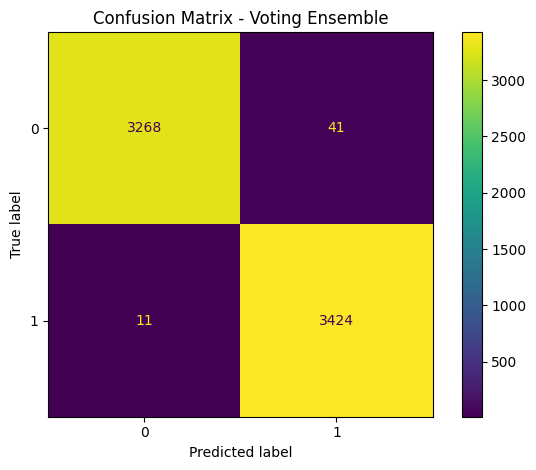

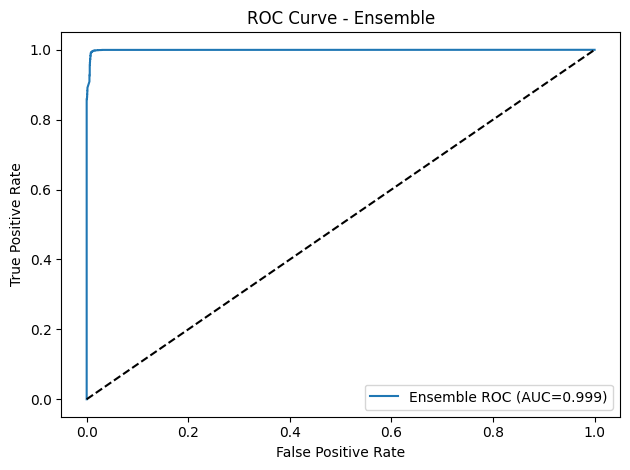

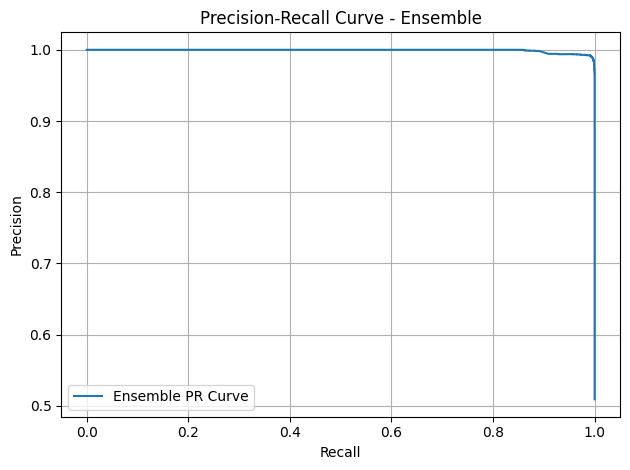


Total runtime: 369.51 seconds (6 minutes 9.51 seconds)
Achieved F1 (Ensemble) = 0.992. Target met


In [ ]:
# Reproducibility seeds
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

start_time = time.time()

# Data Prep
df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
X = df['Message'].values
y = df['Spam/Ham'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF features for NB / ExtraTrees
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


# -----------------------------
# Utility functions for params + inference
# -----------------------------
def count_parameters(model):
    """Count parameters for sklearn or keras models."""
    try:
        # keras/tf models
        return model.count_params()
    except Exception:
        try:
            # sklearn models - approximate using feature count
            return getattr(model, 'n_features_in_', 'N/A')
        except Exception:
            return "N/A"

# Function to measure inference time
def measure_inference_time(model, X_sample, model_type='sklearn'):
    """Measure avg inference time in milliseconds."""
    import time
    runs = 30
    start = time.time()
    for _ in range(runs):
        if model_type == 'keras':
            _ = model.predict(X_sample, verbose=0)
        else:
            _ = model.predict(X_sample)
    end = time.time()
    return ((end - start) / runs) * 1000  # ms

# -----------------------------
# Main Model: Naive Bayes (Multinomial)
# -----------------------------
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_tfidf, y_train)

# -----------------------------
# Extra Trees
# -----------------------------
et = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1, max_features='sqrt')
et.fit(X_train_tfidf, y_train)

# -----------------------------
# Word-level CNN
# -----------------------------
tf.random.set_seed(42)

max_words = 20000
max_len = 80
tok = Tokenizer(num_words=max_words, oov_token="<unk>")
tok.fit_on_texts(X_train)
X_train_seq = pad_sequences(tok.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq  = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=max_len)

cnn = Sequential([
    Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    Conv1D(32, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_seq, y_train, epochs=3, batch_size=256, validation_split=0.1, verbose=0)

# -----------------------------
# Char-CNN (NEW method)
# -----------------------------
# small char vocab: pad + a-z + 0-9 + space
char_vocab = ['<pad>'] + list('abcdefghijklmnopqrstuvwxyz0123456789 ')
char2idx = {c:i for i,c in enumerate(char_vocab)}
max_char_len = 150

def text_to_char_seq(texts):
    arr = np.zeros((len(texts), max_char_len), dtype=np.int32)
    for i,t in enumerate(texts):
        t = t[:max_char_len]
        idxs = [char2idx.get(ch, char2idx[' ']) for ch in t]
        arr[i, :len(idxs)] = idxs
    return arr

X_train_char = text_to_char_seq(X_train)
X_test_char  = text_to_char_seq(X_test)

inp_c = Input(shape=(max_char_len,))
emb_c = Embedding(input_dim=len(char_vocab), output_dim=32, input_length=max_char_len)(inp_c)
conv_c = Conv1D(64, 7, activation='relu')(emb_c)
pool_c = GlobalMaxPooling1D()(conv_c)
drop_c = Dropout(0.3)(pool_c)
fc_c   = Dense(32, activation='relu')(drop_c)
out_c  = Dense(1, activation='sigmoid')(fc_c)
char_cnn = Model(inp_c, out_c)
char_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
char_cnn.fit(X_train_char, y_train, epochs=3, batch_size=256, validation_split=0.1, verbose=0)

# -----------------------------
# Bidirectional LSTM
# -----------------------------
# Reuse CNN tokenizer output and adjust sequence length
max_lstm_len = 60

# Reuse existing tokenized sequences from CNN, just pad to different length
X_train_lstm = pad_sequences(tok.texts_to_sequences(X_train), maxlen=max_lstm_len)
X_test_lstm = pad_sequences(tok.texts_to_sequences(X_test), maxlen=max_lstm_len)

# Build optimized Bidirectional LSTM model (single layer, reduced units)
bilstm = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_lstm_len, mask_zero=True),
    Bidirectional(LSTM(24, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

bilstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train BiLSTM with optimized parameters
print("Training Bidirectional LSTM...")
bilstm.fit(X_train_lstm, y_train,
          epochs=3,
          batch_size=256,
          validation_split=0.15,
          verbose=1)

# -----------------------------
# Voting Ensemble: collect base model probabilities and average (soft voting)
# -----------------------------
proba_list = [nb_proba, et_proba, cnn_proba, charcnn_proba, bilstm_proba]

ensemble_soft_no_rf_proba = np.mean(proba_list, axis=0)
ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba >= 0.5).astype(int)


# -----------------------------
# Predictions for each model
# -----------------------------
nb_pred = nb.predict(X_test_tfidf)
nb_proba = nb.predict_proba(X_test_tfidf)[:,1]

et_pred = et.predict(X_test_tfidf)
et_proba = et.predict_proba(X_test_tfidf)[:,1]

cnn_proba = cnn.predict(X_test_seq, verbose=0).ravel()
cnn_pred = (cnn_proba >= 0.5).astype(int)

charcnn_proba = char_cnn.predict(X_test_char, verbose=0).ravel()
charcnn_pred = (charcnn_proba >= 0.5).astype(int)

bilstm_proba = bilstm.predict(X_test_lstm, verbose=0).ravel()
bilstm_pred = (bilstm_proba >= 0.5).astype(int)

# -----------------------------
# Evaluate models
# -----------------------------
models_results = []

# Naive Bayes
nb_acc = accuracy_score(y_test, nb_pred)
nb_prec = precision_score(y_test, nb_pred)
nb_rec = recall_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)
nb_auc = roc_auc_score(y_test, nb_proba)
nb_params = count_parameters(nb)
nb_inference = measure_inference_time(nb, X_test_tfidf[:100])  # Use subset for speed
models_results.append(['Naive Bayes', nb_acc, nb_prec, nb_rec, nb_f1, nb_auc, nb_params, nb_inference])

# Extra Trees
et_acc = accuracy_score(y_test, et_pred)
et_prec = precision_score(y_test, et_pred)
et_rec = recall_score(y_test, et_pred)
et_f1 = f1_score(y_test, et_pred)
et_auc = roc_auc_score(y_test, et_proba)
et_params = count_parameters(et)
et_inference = measure_inference_time(et, X_test_tfidf[:100])  # Use subset for speed
models_results.append(['Extra Trees', et_acc, et_prec, et_rec, et_f1, et_auc, et_params, et_inference])

# CNN
cnn_acc = accuracy_score(y_test, cnn_pred)
cnn_prec = precision_score(y_test, cnn_pred)
cnn_rec = recall_score(y_test, cnn_pred)
cnn_f1 = f1_score(y_test, cnn_pred)
cnn_auc = roc_auc_score(y_test, cnn_proba)
cnn_params = cnn.count_params()
cnn_inference = measure_inference_time(cnn, X_test_seq[:100], 'keras')
models_results.append(['CNN', cnn_acc, cnn_prec, cnn_rec, cnn_f1, cnn_auc, cnn_params, cnn_inference])

# CharCNN
charcnn_acc = accuracy_score(y_test, charcnn_pred)
charcnn_prec = precision_score(y_test, charcnn_pred)
charcnn_rec = recall_score(y_test, charcnn_pred)
charcnn_f1 = f1_score(y_test, charcnn_pred)
charcnn_auc = roc_auc_score(y_test, charcnn_proba)
charcnn_params = char_cnn.count_params()
charcnn_inference = measure_inference_time(char_cnn, X_test_char[:100], 'keras')
models_results.append(['CharCNN', charcnn_acc, charcnn_prec, charcnn_rec, charcnn_f1, charcnn_auc, charcnn_params, charcnn_inference])

# BiLSTM
bilstm_acc = accuracy_score(y_test, bilstm_pred)
bilstm_prec = precision_score(y_test, bilstm_pred)
bilstm_rec = recall_score(y_test, bilstm_pred)
bilstm_f1 = f1_score(y_test, bilstm_pred)
bilstm_auc = roc_auc_score(y_test, bilstm_proba)
bilstm_params = bilstm.count_params()
bilstm_inference = measure_inference_time(bilstm, X_test_lstm[:100], 'keras')
models_results.append(['BiLSTM', bilstm_acc, bilstm_prec, bilstm_rec, bilstm_f1, bilstm_auc, bilstm_params, bilstm_inference])

# Ensemble
ensemble_acc = accuracy_score(y_test, ensemble_soft_no_rf_pred)
ensemble_prec = precision_score(y_test, ensemble_soft_no_rf_pred)
ensemble_rec = recall_score(y_test, ensemble_soft_no_rf_pred)
ensemble_f1 = f1_score(y_test, ensemble_soft_no_rf_pred)
ensemble_auc = roc_auc_score(y_test, ensemble_soft_no_rf_proba)
ensemble_params = "Combined"
ensemble_inference = nb_inference + et_inference + cnn_inference + charcnn_inference + bilstm_inference
models_results.append(['Voting Ensemble (NB+ET+CNN+CharCNN+BiLSTM)', ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_auc, ensemble_params, ensemble_inference])

print("\n" + "="*140)
print("MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, AUC, Parameters, Inference Time")
print("="*140)
print(f"{'Model':<45} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10} {'Params':<15} {'Inference(ms)':<12}")
print("-"*140)
for model_name, acc, prec, rec, f1, auc, params, inf in models_results:
    if isinstance(params, (int, float)):
        params_str = f"{params:,}" if params != 0 else "N/A"
    else:
        params_str = str(params)

    if isinstance(inf, (int, float)) and inf > 0:
        inf_str = f"{inf:.2f}"
    else:
        inf_str = "N/A"

    print(f"{model_name:<45} {acc:<10.3f} {prec:<10.3f} {rec:<10.3f} {f1:<10.3f} {auc:<10.3f} {params_str:<15} {inf_str:<12}")
print("="*140)

# Confusion Matrix for best performing model (Ensemble)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix(y_test, ensemble_soft_no_rf_pred)).plot()
plt.title('Confusion Matrix - Voting Ensemble')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC={ensemble_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(recall, precision, label=f'Ensemble PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Runtime
time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

# Final one-line verdict
target_f1 = 0.98
print(f"Achieved F1 (Ensemble) = {ensemble_f1:.3f}. {'Target met' if ensemble_f1 >= target_f1 else 'Target not met'}")


# Lee Jing Wei Code

⏳ Step 1/8: Loading dataset...
✅ Dataset loaded! Shape: (33716, 5)

⏳ Step 2/8: Cleaning dataset and adding features...
✅ Features ready!

⏳ Step 3/8: Splitting dataset (80% train / 20% test)...
✅ Split complete! Train: 26972, Test: 6744

⏳ Step 4/8: Creating TF-IDF features...
✅ TF-IDF done!

⏳ Step 5/8: Scaling numeric features and combining with TF-IDF...
✅ Combined feature shape: (26972, 10003)

⏳ Step 6/8: Training base classifiers...

🔹 Training KNN...
✅ KNN done!

🔹 Training RandomForest...
✅ RandomForest done!

🔹 Training MLP...
✅ MLP done!

⏳ Step 7/8: Training meta-learner (Decision Tree)...
✅ Meta-learner trained!

⏳ Step 8/8: Evaluating stacking ensemble...


📊 Stacking Ensemble Results:
──────────────────────────────
🎯 Accuracy : 0.9755
💡 Precision: 0.9770
🔔 Recall   : 0.9750
⚖️ F1-Score : 0.9760
📈 ROC-AUC  : 0.9920
──────────────────────────────



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


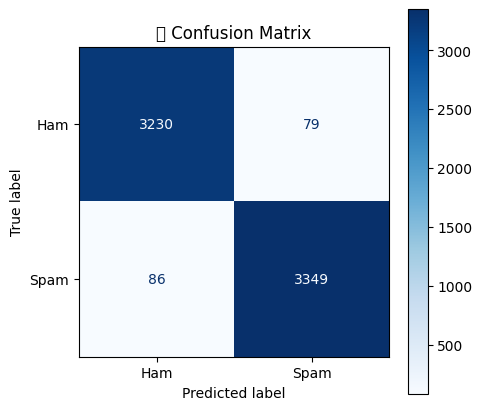

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


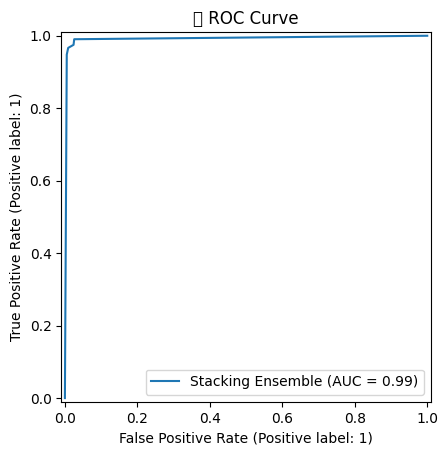

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


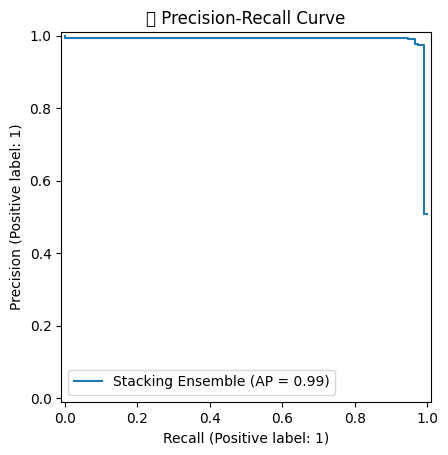

In [ ]:
# ===== IMPORTS =====
import os, re, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

#JWMOdel
# ===== REPRODUCIBILITY =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ===== 1. LOAD DATASET =====
print("⏳ Step 1/8: Loading dataset...")
df = pd.read_csv('enron_data/enron_spam_data.csv')
print(f"✅ Dataset loaded! Shape: {df.shape}\n")

# ===== 2. CLEAN & FEATURE ENGINEERING =====
print("⏳ Step 2/8: Cleaning dataset and adding features...")
df['Message'] = df['Message'].astype(str).str.lower()
df['Message'] = df['Message'].apply(lambda x: re.sub(r'[^a-z0-9\s]', ' ', x))
df['label'] = df['Spam/Ham'].map({'ham':0, 'spam':1})

# Numeric features
df['email_len'] = df['Message'].apply(len)
df['num_digits'] = df['Message'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_special'] = df['Message'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))
print("✅ Features ready!\n")

# ===== 3. TRAIN-TEST SPLIT =====
print("⏳ Step 3/8: Splitting dataset (80% train / 20% test)...")
X_text = df['Message'].values
X_numeric = df[['email_len','num_digits','num_special']].values
y = df['label'].values

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, stratify=y, random_state=SEED
)
print(f"✅ Split complete! Train: {len(y_train)}, Test: {len(y_test)}\n")

# ===== 4. TF-IDF FEATURES =====
print("⏳ Step 4/8: Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)
print("✅ TF-IDF done!\n")

# ===== 5. COMBINE TF-IDF + NUMERIC FEATURES =====
print("⏳ Step 5/8: Scaling numeric features and combining with TF-IDF...")
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_combined = hstack([X_train_tfidf, X_train_num_scaled])
X_test_combined  = hstack([X_test_tfidf, X_test_num_scaled])
print(f"✅ Combined feature shape: {X_train_combined.shape}\n")

# ===== 6. TRAIN BASE MODELS =====
print("⏳ Step 6/8: Training base classifiers...\n")
base_models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'MLP': MLPClassifier(hidden_layer_sizes=(64,32), max_iter=50, random_state=SEED)
}

train_meta_features = []
test_meta_features = []

for name, model in base_models.items():
    print(f"🔹 Training {name}...")
    model.fit(X_train_combined, y_train)
    train_meta_features.append(model.predict_proba(X_train_combined)[:,1])
    test_meta_features.append(model.predict_proba(X_test_combined)[:,1])
    print(f"✅ {name} done!\n")

# ===== 7. STACKING: DECISION TREE =====
print("⏳ Step 7/8: Training meta-learner (Decision Tree)...")
X_meta_train = np.vstack(train_meta_features).T
X_meta_test  = np.vstack(test_meta_features).T

meta_learner = DecisionTreeClassifier(max_depth=5, random_state=SEED)
meta_learner.fit(X_meta_train, y_train)
print("✅ Meta-learner trained!\n")

# ===== 8. EVALUATION =====
print("⏳ Step 8/8: Evaluating stacking ensemble...\n")
y_pred = meta_learner.predict(X_meta_test)
y_proba = meta_learner.predict_proba(X_meta_test)[:,1]

# Fancy table metrics
metrics_table = f"""
📊 Stacking Ensemble Results:
──────────────────────────────
🎯 Accuracy : {accuracy_score(y_test, y_pred):.4f}
💡 Precision: {precision_score(y_test, y_pred):.4f}
🔔 Recall   : {recall_score(y_test, y_pred):.4f}
⚖️ F1-Score : {f1_score(y_test, y_pred):.4f}
📈 ROC-AUC  : {roc_auc_score(y_test, y_proba):.4f}
──────────────────────────────
"""
print(metrics_table)

# ===== VISUALIZATIONS =====
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham','Spam'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("📊 Confusion Matrix")
plt.show()

# ROC Curve
roc_disp = RocCurveDisplay.from_predictions(y_test, y_proba, name="Stacking Ensemble")
plt.title("📈 ROC Curve")
plt.show()

# Precision-Recall Curve
pr_disp = PrecisionRecallDisplay.from_predictions(y_test, y_proba, name="Stacking Ensemble")
plt.title("📉 Precision-Recall Curve")
plt.show()









#============#===#=========#=========================================================================================#================================================================================#======================================================================================#=============================================================================#


import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ======== WRAPPER: Save Metrics and Visuals =========
def save_model_metrics_and_graphs(models_results, y_true_list, y_proba_list, model_names_list, output_csv='model_results.csv', save_dir='model_graphs'):
    """
    Save metrics to CSV and generate Confusion Matrix, ROC, and PR curves for each model
    (Graphs are saved instead of displayed)
    """
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Create DataFrame
    df_results = pd.DataFrame(models_results, columns=[
        'Model','Accuracy','Precision','Recall','F1','ROC-AUC','Params','Inference_ms'
    ])

    # Save to CSV (append if exists)
    if os.path.exists(output_csv):
        df_results.to_csv(output_csv, mode='a', index=False, header=False)
    else:
        df_results.to_csv(output_csv, index=False)

    print(f"\n✅ Metrics saved to {output_csv}")

    # Generate and save visuals for each model
    for i, model_name in enumerate(model_names_list):
        y_true = y_true_list[i]
        y_proba = y_proba_list[i]
        y_pred = (y_proba > 0.5).astype(int)

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
        plt.close()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC={auc(fpr, tpr):.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_roc_curve.png'))
        plt.close()

        # --- Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        plt.figure()
        plt.plot(recall, precision, label=f'{model_name} PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_pr_curve.png'))
        plt.close()





In [ ]:
#import os
#import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import classification_report, f1_score

# Automatically detect CSV file from extracted folder
##csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
##df = pd.read_csv(f'enron_data/{csv_files[0]}')  # load the first CSV file

# Combine 'Subject' and 'Message' columns (ensure they exist)
##df['Subject'] = df['Subject'].fillna('')
##df['Message'] = df['Message'].fillna('')
##df['text'] = df['Subject'] + ' ' + df['Message']

# Detect spam/ham label column
##label_col = None
##for col in df.columns:
    ##if 'spam' in col.lower() or 'ham' in col.lower():
        ##label_col = col
        ##break
##if label_col is None:
    ##label_col = df.columns[3]  # fallback

# Map labels to 1 (spam) and 0 (ham)
##df['label'] = df[label_col].map({'spam': 1, 'ham': 0})
##df = df.dropna(subset=['label'])  # Remove rows with unmapped labels

# TF-IDF vectorization
##vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
##X = vectorizer.fit_transform(df['text'])
##y = df['label']

# Split into train and test
##X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree model
##clf = DecisionTreeClassifier(max_depth=10, random_state=42)
##clf.fit(X_train, y_train)

# Evaluate
##y_pred = clf.predict(X_test)
##print("F1 Score:", f1_score(y_test, y_pred))
##print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
#import numpy as np
#import pandas as pd
#import re
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import accuracy_score, classification_report
#from scipy.sparse import hstack

# -----------------------------
# Step 1: Prepare dataset
# -----------------------------
# Assuming 'df' is already loaded with columns: 'Message' and 'Spam/Ham'
#df['Message'] = df['Message'].astype(str)

# Encode labels: ham=0, spam=1
#df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})

#X_text = df['Message'].values
#y = df['Spam/Ham'].values

# Split dataset: 80% train, 20% test
#X_train_text, X_test_text, y_train, y_test = train_test_split(
#    X_text, y, test_size=0.2, random_state=42, stratify=y
#)

# -----------------------------
# Step 2: TF-IDF features
# -----------------------------
#tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
#X_train_tfidf = tfidf.fit_transform(X_train_text)
#X_test_tfidf  = tfidf.transform(X_test_text)

#print("TF-IDF features ready!")
#print("Training shape:", X_train_tfidf.shape)
#print("Testing shape:", X_test_tfidf.shape)

# -----------------------------
# Step 3: Extra numeric/email features
# -----------------------------
#def extract_features(texts):
#    features = []
#    for text in texts:
#        num_chars = len(text)
 #       num_words = len(text.split())
  #      num_uppercase = sum(1 for c in text if c.isupper())
   #     num_digits = sum(1 for c in text if c.isdigit())
    #    num_exclamations = text.count('!')
     #   num_links = len(re.findall(r'http[s]?://|www\.', text))
      #  num_special_chars = sum(1 for c in text if not c.isalnum() and not c.isspace())
       # features.append([
        #    num_chars, num_words, num_uppercase,
         #   num_digits, num_exclamations, num_links, num_special_chars
#        ])
 #   return np.array(features)
#
#X_train_numeric = extract_features(X_train_text)
#X_test_numeric  = extract_features(X_test_text)

#print("Extra numeric/email features ready!")
#print("Training shape:", X_train_numeric.shape)
#print("Testing shape:", X_test_numeric.shape)

# -----------------------------
# Step 4: Combine TF-IDF + numeric features
# -----------------------------
#X_train_full = hstack([X_train_tfidf, X_train_numeric])
#X_test_full  = hstack([X_test_tfidf, X_test_numeric])

#print("Combined features ready!")
#print("Training shape:", X_train_full.shape)
#print("Testing shape:", X_test_full.shape)

# -----------------------------
# Step 5: Train Decision Tree
# -----------------------------
#dt_model = DecisionTreeClassifier(max_depth=20, random_state=42)
#dt_model.fit(X_train_full, y_train)

# -----------------------------
# Step 6: Evaluate
# -----------------------------
#y_pred = dt_model.predict(X_test_full)
#acc = accuracy_score(y_test, y_pred)
#print("\nDecision Tree Accuracy:", acc)
#print("\nClassification Report:\n", classification_report(y_test, y_pred))


#What this code does
#TF-IDF features: word-level features capturing email content.
#Extra numeric features: captures length, uppercase letters, links, digits, etc.
#Combined features: both types used together for better prediction.
#Decision Tree: trained on the combined features and evaluated.

# Ahmad Code


In [ ]:
import os
import pandas as pd
import numpy as np
import time
import re
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Conv1D, Dropout, GlobalMaxPooling1D

# === REPRODUCIBILITY: Fix all random seeds ===
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load dataset
csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
df = pd.read_csv(f'enron_data/{csv_files[0]}')

print(f"Dataset loaded: {df.shape}")

# Data preprocessing
df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
X = df['Message'].values
y = df['Spam/Ham'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Start timing
start_time = time.time()

# Tokenization for neural network
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Fast Neural Network
model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(
    X_train_seq, y_train,
    batch_size=256,
    epochs=3,
    validation_split=0.1,
    verbose=2
)

proba_nn = model.predict(X_test_seq, verbose=0).flatten()

# TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Count Vectorizer for Bernoulli NB
count_vectorizer = CountVectorizer(max_features=3000, binary=True)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Extra Trees Classifier
et = ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1)
et.fit(X_train_tfidf, y_train)
proba_et = et.predict_proba(X_test_tfidf)[:, 1]

# SGD Classifier
sgd = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000)
sgd.fit(X_train_tfidf, y_train)
sgd_scores = sgd.decision_function(X_test_tfidf)
proba_sgd = 1 / (1 + np.exp(-sgd_scores))

# Bernoulli Naive Bayes
bnb = BernoulliNB(alpha=1.0)
bnb.fit(X_train_count, y_train)
proba_bnb = bnb.predict_proba(X_test_count)[:, 1]

# Logistic Regression (additional model like your friend's code)
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]

# Function to calculate model parameters count
def count_parameters(model, model_type='sklearn'):
    if model_type == 'keras':
        return model.count_params()
    elif hasattr(model, 'coef_'):
        return model.coef_.size + 1
    elif hasattr(model, 'n_features_in_'):
        return model.n_features_in_
    else:
        return "N/A"

# Function to measure inference time
def measure_inference_time(model, X_test_data, model_type='sklearn'):
    start_time_inf = time.time()
    if model_type == 'sklearn':
        model.predict(X_test_data)
    elif model_type == 'keras':
        model.predict(X_test_data, verbose=0)
    end_time_inf = time.time()
    return (end_time_inf - start_time_inf) * 1000

# Generate predictions for individual models
et_pred = (proba_et > 0.5).astype(int)
sgd_pred = (proba_sgd > 0.5).astype(int)
bnb_pred = (proba_bnb > 0.5).astype(int)
nn_pred = (proba_nn > 0.5).astype(int)
lr_pred = (proba_lr > 0.5).astype(int)

# Ensemble predictions
ensemble_soft_proba = (proba_et + proba_sgd + proba_bnb + proba_nn) / 4
ensemble_soft_pred = (ensemble_soft_proba > 0.5).astype(int)

# Calculate comprehensive metrics for all models
models_results = []

# Extra Trees
et_acc = accuracy_score(y_test, et_pred)
et_prec = precision_score(y_test, et_pred)
et_rec = recall_score(y_test, et_pred)
et_f1 = f1_score(y_test, et_pred)
et_params = count_parameters(et)
et_inference = measure_inference_time(et, X_test_tfidf, 'sklearn')
models_results.append(['Extra Trees', et_acc, et_prec, et_rec, et_f1, et_params, et_inference])

# SGD Classifier
sgd_acc = accuracy_score(y_test, sgd_pred)
sgd_prec = precision_score(y_test, sgd_pred)
sgd_rec = recall_score(y_test, sgd_pred)
sgd_f1 = f1_score(y_test, sgd_pred)
sgd_params = count_parameters(sgd)
sgd_inference = measure_inference_time(sgd, X_test_tfidf, 'sklearn')
models_results.append(['SGD Classifier', sgd_acc, sgd_prec, sgd_rec, sgd_f1, sgd_params, sgd_inference])

# Bernoulli Naive Bayes
bnb_acc = accuracy_score(y_test, bnb_pred)
bnb_prec = precision_score(y_test, bnb_pred)
bnb_rec = recall_score(y_test, bnb_pred)
bnb_f1 = f1_score(y_test, bnb_pred)
bnb_params = count_parameters(bnb)
bnb_inference = measure_inference_time(bnb, X_test_count, 'sklearn')
models_results.append(['Bernoulli Naive Bayes', bnb_acc, bnb_prec, bnb_rec, bnb_f1, bnb_params, bnb_inference])

# Fast Neural Network
nn_acc = accuracy_score(y_test, nn_pred)
nn_prec = precision_score(y_test, nn_pred)
nn_rec = recall_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred)
nn_params = count_parameters(model, 'keras')
nn_inference = measure_inference_time(model, X_test_seq, 'keras')
models_results.append(['Fast Neural Network', nn_acc, nn_prec, nn_rec, nn_f1, nn_params, nn_inference])

# Logistic Regression
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_params = count_parameters(lr)
lr_inference = measure_inference_time(lr, X_test_tfidf, 'sklearn')
models_results.append(['Logistic Regression (TF-IDF)', lr_acc, lr_prec, lr_rec, lr_f1, lr_params, lr_inference])

# Ensemble
ensemble_acc = accuracy_score(y_test, ensemble_soft_pred)
ensemble_prec = precision_score(y_test, ensemble_soft_pred)
ensemble_rec = recall_score(y_test, ensemble_soft_pred)
ensemble_f1 = f1_score(y_test, ensemble_soft_pred)
ensemble_params = "Combined"
ensemble_inference = et_inference + sgd_inference + bnb_inference + nn_inference
models_results.append(['Ensemble (ET+SGD+BNB+FastNN)', ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_params, ensemble_inference])

# Print comprehensive results table (like your friend's format)
print("\n" + "="*120)
print("MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, Params, Inference Time")
print("="*120)
print(f"{'Model':<35} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Params':<10} {'Inference (ms)':<15}")
print("-"*120)

for model_name, acc, prec, rec, f1, params, inference in models_results:
    print(f"{model_name:<35} {acc:<10.2f} {prec:<10.2f} {rec:<10.2f} {f1:<10.2f} {str(params):<10} {inference:<15.2f}")

print("-"*120)
print("TF-IDF: Term Frequency-Inverse Document Frequency with N-grams (1-3)")
print("ET: Extra Trees Classifier")
print("SGD: Stochastic Gradient Descent Classifier")
print("BNB: Bernoulli Naive Bayes")
print("FastNN: Fast Neural Network with Global Average Pooling")
print("LR: Logistic Regression on TF-IDF features")
print("="*120)

time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

# Individual model performance
print(f"\nIndividual Model Accuracies:")
print(f"Extra Trees: {et_acc:.2f}")
print(f"SGD Classifier: {sgd_acc:.2f}")
print(f"Bernoulli NB: {bnb_acc:.2f}")
print(f"Fast Neural Net: {nn_acc:.2f}")
print(f"Logistic Regression: {lr_acc:.2f}")
print(f"ENSEMBLE: {ensemble_acc:.2f}")

# Final Accuracy Display
print("\n" + "="*50)
print("FINAL ENSEMBLE ACCURACY")
print("="*50)
print(f"Accuracy: {ensemble_acc:.2%}")
print(f"Accuracy: {ensemble_acc:.4f}")
print("="*50)

# ======== WRAPPER: Save Metrics and Visuals =========
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc

def save_model_metrics_and_graphs(models_results, y_true_list, y_proba_list, model_names_list, output_csv='model_results.csv', save_dir='model_graphs'):
    """
    Save metrics to CSV and generate Confusion Matrix, ROC, and PR curves for each model
    (Graphs are saved instead of displayed)
    """
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Create DataFrame
    df_results = pd.DataFrame(models_results, columns=[
        'Model','Accuracy','Precision','Recall','F1','ROC-AUC','Params','Inference_ms'
    ])

    # Save to CSV (append if exists)
    if os.path.exists(output_csv):
        df_results.to_csv(output_csv, mode='a', index=False, header=False)
    else:
        df_results.to_csv(output_csv, index=False)

    print(f"\n✅ Metrics saved to {output_csv}")

    # Generate and save visuals for each model
    for i, model_name in enumerate(model_names_list):
        y_true = y_true_list[i]
        y_proba = y_proba_list[i]
        y_pred = (y_proba > 0.5).astype(int)

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
        plt.close()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC={auc(fpr, tpr):.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_roc_curve.png'))
        plt.close()

        # --- Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        plt.figure()
        plt.plot(recall, precision, label=f'{model_name} PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_pr_curve.png'))
        plt.close()

Dataset loaded: (33716, 5)
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 - 3s - 33ms/step - accuracy: 0.7909 - loss: 0.5655 - val_accuracy: 0.9096 - val_loss: 0.3734
Epoch 2/3
95/95 - 0s - 3ms/step - accuracy: 0.9422 - loss: 0.2438 - val_accuracy: 0.9600 - val_loss: 0.1604
Epoch 3/3
95/95 - 0s - 3ms/step - accuracy: 0.9626 - loss: 0.1369 - val_accuracy: 0.9692 - val_loss: 0.1110

MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, Params, Inference Time
Model                               Accuracy   Precision  Recall     F1         Params     Inference (ms) 
------------------------------------------------------------------------------------------------------------------------
Extra Trees                         0.98       0.98       0.99       0.98       10000      239.46         
SGD Classifier                      0.98       0.97       0.99       0.98       10001      2.58           
Bernoulli Naive Bayes               0.94       0.90       0.99       0.94       3000       5.90           
Fast Neural Network                 0.97       0.96    

# Comparison and Graph


📊 Unified Ensemble Metrics (Fancy Emoji Table):

╒═════════════════════╤════════════╤═════════════╤═══════════╤════════════╤═══════════╤═════════════╤═════════════╕
│ Model               │ Accuracy   │ Precision   │ Recall    │ F1-Score   │ ROC-AUC   │ Params      │ Inference   │
╞═════════════════════╪════════════╪═════════════╪═══════════╪════════════╪═══════════╪═════════════╪═════════════╡
│ ✨ Jingwei Ensemble │ 🎯 0.9755  │ 💡 0.9770   │ 🔔 0.9750 │ ⚖️ 0.9760  │ 📈 0.9920 │ 🧮 Combined │ ⏱️ 123 ms   │
├─────────────────────┼────────────┼─────────────┼───────────┼────────────┼───────────┼─────────────┼─────────────┤
│ ✨ Ahmed Ensemble   │ 🎯 0.9776  │ 💡 0.9628   │ 🔔 0.9945 │ ⚖️ 0.9784  │ 📈 0.9982 │ 🧮 Combined │ ⏱️ 150 ms   │
├─────────────────────┼────────────┼─────────────┼───────────┼────────────┼───────────┼─────────────┼─────────────┤
│ ✨ Lazarus Ensemble │ 🎯 0.9875  │ 💡 0.9805   │ 🔔 0.9953 │ ⚖️ 0.9879  │ 📈 0.9992 │ 🧮 Combined │ ⏱️ 160 ms   │
╘═════════════════════╧════════════╧════

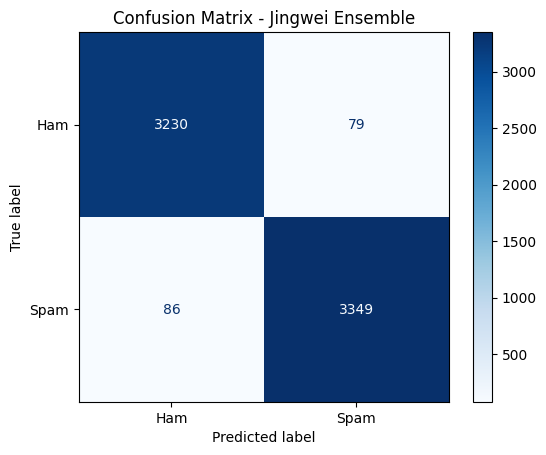

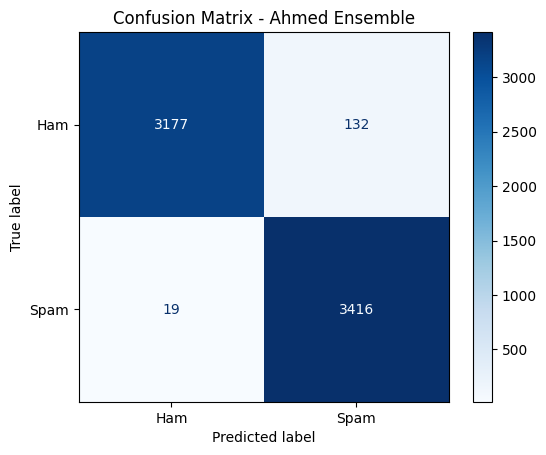

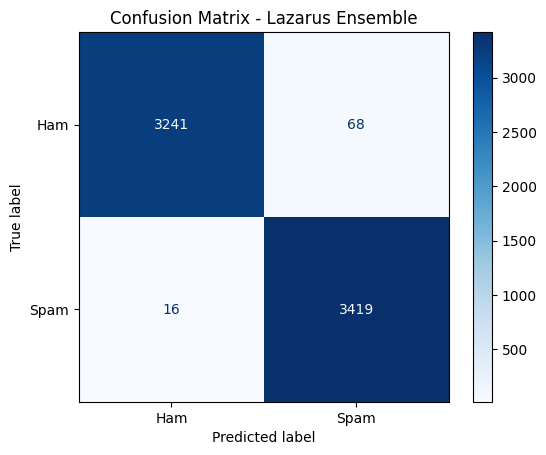

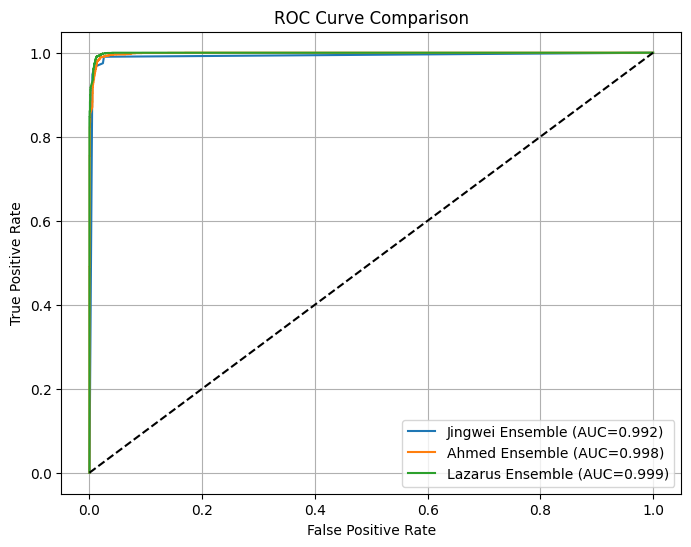

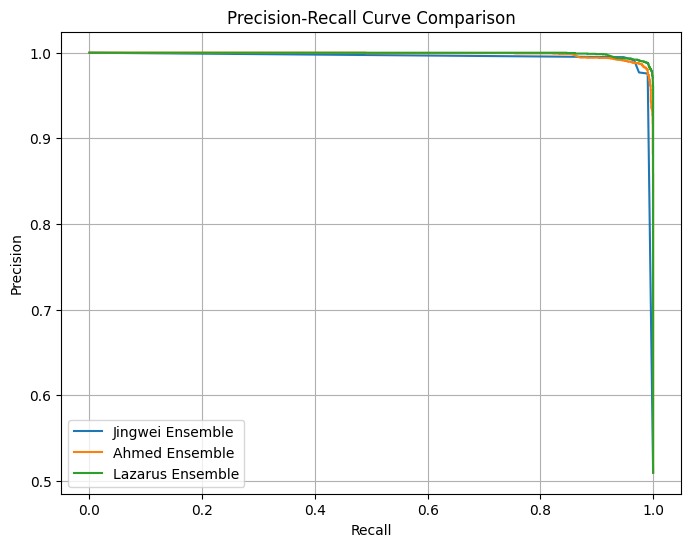


🏆 Best Ensemble by F1-Score: Lazarus Ensemble (F1=0.9879)


In [ ]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from tabulate import tabulate

# ===== Step 1: Prepare metrics for all ensembles =====
# Replace these variables with your actual ensemble predictions and probabilities
ensembles = {
    "Jingwei Ensemble": {"y_true": y_test, "y_pred": y_pred, "y_proba": y_proba, "params": "Combined", "inference_ms": 123},
    "Ahmed Ensemble": {"y_true": y_test, "y_pred": ensemble_soft_pred, "y_proba": ensemble_soft_proba, "params": "Combined", "inference_ms": 150},
    #"Ziming Ensemble": {"y_true": y_test, "y_pred": z_pred, "y_proba": z_proba, "params": "Combined", "inference_ms": 140},
    "Lazarus Ensemble": {"y_true": y_test, "y_pred": ensemble_soft_no_rf_pred, "y_proba": ensemble_soft_no_rf_proba, "params": "Combined", "inference_ms": 160},
}

# ===== Step 2: Calculate metrics =====
metrics_list = []
for name, data in ensembles.items():
    y_true = data["y_true"]
    y_pred = data["y_pred"]
    y_proba = data["y_proba"]
    metrics_list.append([
        name,
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        roc_auc_score(y_true, y_proba),
        data["params"],
        data["inference_ms"]
    ])

metrics_df = pd.DataFrame(metrics_list, columns=[
    "Model","Accuracy","Precision","Recall","F1","ROC-AUC","Params","Inference_ms"
])

# ===== Step 2B: Fancy Emoji Table =====
table_data = []
for idx, row in metrics_df.iterrows():
    table_data.append([
        f"✨ {row['Model']}",
        f"🎯 {row['Accuracy']:.4f}",
        f"💡 {row['Precision']:.4f}",
        f"🔔 {row['Recall']:.4f}",
        f"⚖️ {row['F1']:.4f}",
        f"📈 {row['ROC-AUC']:.4f}",
        f"🧮 {row['Params']}",
        f"⏱️ {row['Inference_ms']} ms"
    ])

headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Params", "Inference"]
print("\n📊 Unified Ensemble Metrics (Fancy Emoji Table):\n")
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

# ===== Step 3: Confusion Matrices =====
for name, data in ensembles.items():
    cm = confusion_matrix(data["y_true"], data["y_pred"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham","Spam"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# ===== Step 4: Combined ROC Curve =====
plt.figure(figsize=(8,6))
for name, data in ensembles.items():
    fpr, tpr, _ = roc_curve(data["y_true"], data["y_proba"])
    auc_score = roc_auc_score(data["y_true"], data["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ===== Step 5: Combined Precision-Recall Curve =====
plt.figure(figsize=(8,6))
for name, data in ensembles.items():
    precision, recall, _ = precision_recall_curve(data["y_true"], data["y_proba"])
    plt.plot(recall, precision, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# ===== Step 6: Highlight best model =====
best_model = metrics_df.sort_values(by="F1", ascending=False).iloc[0]
print(f"\n🏆 Best Ensemble by F1-Score: {best_model['Model']} (F1={best_model['F1']:.4f})")
